# Sales Data Analysis of Chocolate Sales

## 1. Introduction

This report presents a comprehensive data analysis and segmentation of a chocolate sales dataset. The objective is to extract actionable insights about sales performance, profit distribution, and salesperson behavior across different order types, countries, and products.

The report follows this structure:

1. **Data Exploration** – Understanding the structure, cleaning inconsistencies, and transforming key variables.
2. **KPI Analysis** – Measuring performance by order size, average profit, and total sales.
3. **Dimensionality Reduction** – Applying Principal Component Analysis (PCA) to identify the most influential variables and reduce redundancy.
4. **Behavioral Clustering** – Using KMeans to group salespeople based on commercial behavior, enriched with country and product dimensions.
5. **Interpretation** – Profiling each cluster and drawing business conclusions for strategic action.



## 2. Data loading and first look

In [1]:
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Getting the dataset directly from the Kaggle API:

In [2]:
path = kagglehub.dataset_download("atharvasoundankar/chocolate-sales")
csv_path = os.path.join(path, "Chocolate Sales.csv")

df = pd.read_csv(csv_path)
df.head()


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


We will see a basic information about the dataset, to look for any anomalies or missing values.

In [3]:
print(f"rows: {df.shape[0]}, columns: {df.shape[1]}")
df.info()

rows: 1094, columns: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


Check possible NaNs

In [4]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [5]:
print("Date range:", df["Date"].min(), "->", df["Date"].max())

Date range: 01-Apr-22 -> 31-May-22


In [6]:
duplicates = df.duplicated()
print(f"duplicated rows: {duplicates.sum()}")

duplicated rows: 0


We can see that this dataset is so clean, that will make our life easier.

## 3. Cleaning the data

In this section, basically we rewrote column names and set correct column types.

In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head()

,sales_person,country,product,date,amount,boxes_shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [8]:
df["date"] = pd.to_datetime(df["date"], format="%d-%b-%y").dt.strftime("%Y-%m-%d")
df["amount"] = df["amount"].replace(r"[\$,]", "", regex=True).astype(float)

df.head()

,sales_person,country,product,date,amount,boxes_shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184


## 4. Exploratory data analysis (EDA)

I think that in business intelligence, the most important thing is to understand the data and the business. So, I will try to make some analysis that can be useful for a business.

I will explain the analysis answering four basic questions:
1. Which are the most sold chocolates?
2. Where are the most sold chocolates?
3. When are the most sold chocolates?
4. How are the most sold chocolates?

It is a subjective decission, but for a first analysis I think that will be far enough to understand the data and the business.

### 4.1. WHICH is the best-selling chocolate?

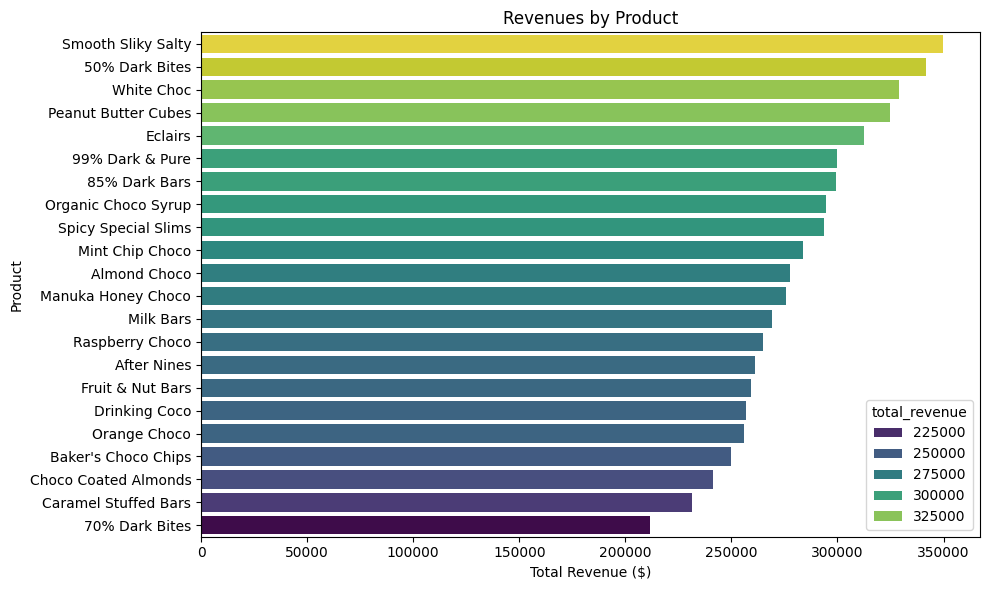

In [9]:
product_revenue = df.groupby("product")["amount"].sum().sort_values(ascending=False).reset_index()
product_revenue.columns = ["product", "total_revenue"]

plt.figure(figsize=(10, 6))
sns.barplot(data=product_revenue, x="total_revenue", y="product", hue="total_revenue", palette="viridis")
plt.title("Revenues by Product")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

### 4.2. WHERE is selling the most chocolate?

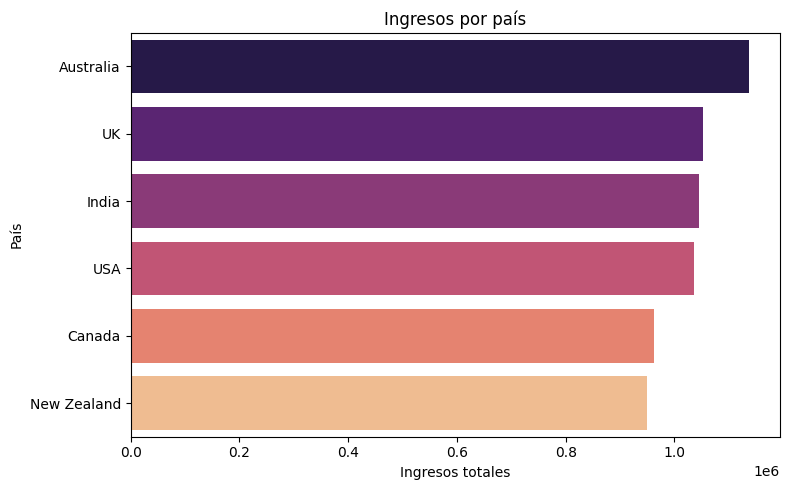

In [10]:
country_revenue = df.groupby('country')['amount'].sum().sort_values(ascending=False).reset_index()
country_revenue.columns = ["country", "total_revenue"]

plt.figure(figsize=(8, 5))
sns.barplot(data=country_revenue, x="total_revenue", y="country", hue="country", palette="magma")
plt.title("Ingresos por país")
plt.xlabel("Ingresos totales")
plt.ylabel("País")
plt.tight_layout()
plt.show()

In [11]:
country_revenue_df = country_revenue.reset_index()

fig = px.choropleth(
    country_revenue_df,
    locations="country",
    locationmode="country names",
    color="total_revenue",
    color_continuous_scale=px.colors.sequential.Viridis[::-1],
    title="Revenues by Country",
    labels={"total_revenue": "Total Revenue ($)"},
)

fig.update_layout(geo=dict(showframe=False, projection_type="natural earth"))
fig.show()

### 4.3. WHEN is selling the most chocolate?

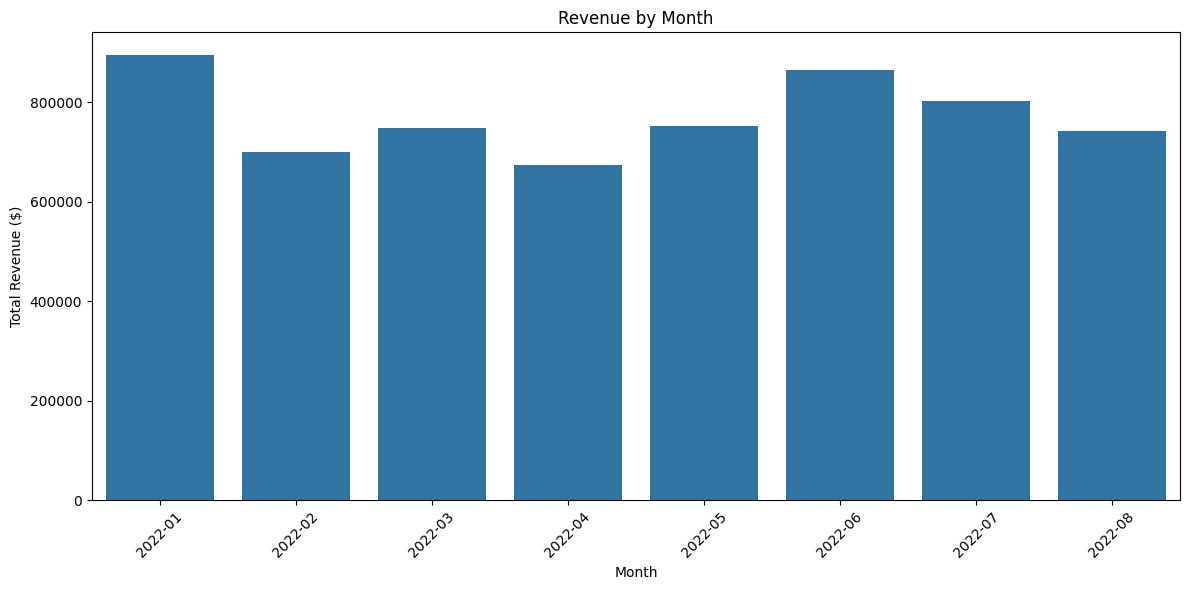

In [12]:
df['month'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

monthly_revenue = df.groupby('month')['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='amount', data=monthly_revenue)
plt.xticks(rotation=45)
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()

### 4.4. HOW is selling the most chocolate?

As we could see, our dataset hasn't lot of columns, so is complicated to extract rigorous conclusions. But I conclude that it's possible to know the behavior of th sales with a perspective of volume and segmentation.

In [13]:
df['price_per_box'] = df['amount'] / df['boxes_shipped']
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000


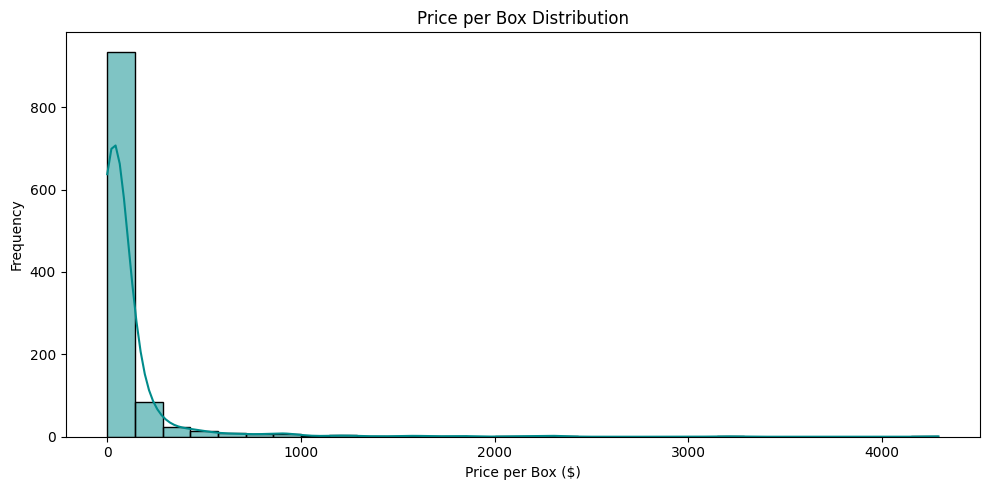

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price_per_box'], bins=30, kde=True, color='darkcyan')
plt.title("Price per Box Distribution")
plt.xlabel("Price per Box ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

I think that a good way to analyze that is to make a segmentation of the sales, and then analyze the behavior of each segment.

First, segmentation by order size, and then by average profit and total sales.

In [15]:
df['order_size'] = pd.cut(
    df['boxes_shipped'],
    bins=[0, 10, 50, df['boxes_shipped'].max()],
    labels=['small', 'medium', 'large']
)
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large


In [16]:
segment_stats = df.groupby("order_size", observed=True).agg({
    "amount": ["sum", "mean"],
    "price_per_box": "mean",
    "boxes_shipped": "mean"
}).round(2)

segment_stats

amount          price_per_box boxes_shipped
                  sum     mean          mean          mean
order_size                                                
small        182385.0  5526.82        1186.4          5.91
medium       950873.0  6056.52         250.1         30.34
large       5050367.0  5586.69          41.2        190.32

In [17]:
segment_stats.columns = ['total_revenue', 'avg_revenue', 'avg_price_per_box', 'avg_boxes']
segment_stats.reset_index(inplace=True)
segment_stats

,order_size,total_revenue,avg_revenue,avg_price_per_box,avg_boxes
0,small,182385.0,5526.82,1186.4,5.91
1,medium,950873.0,6056.52,250.1,30.34
2,large,5050367.0,5586.69,41.2,190.32


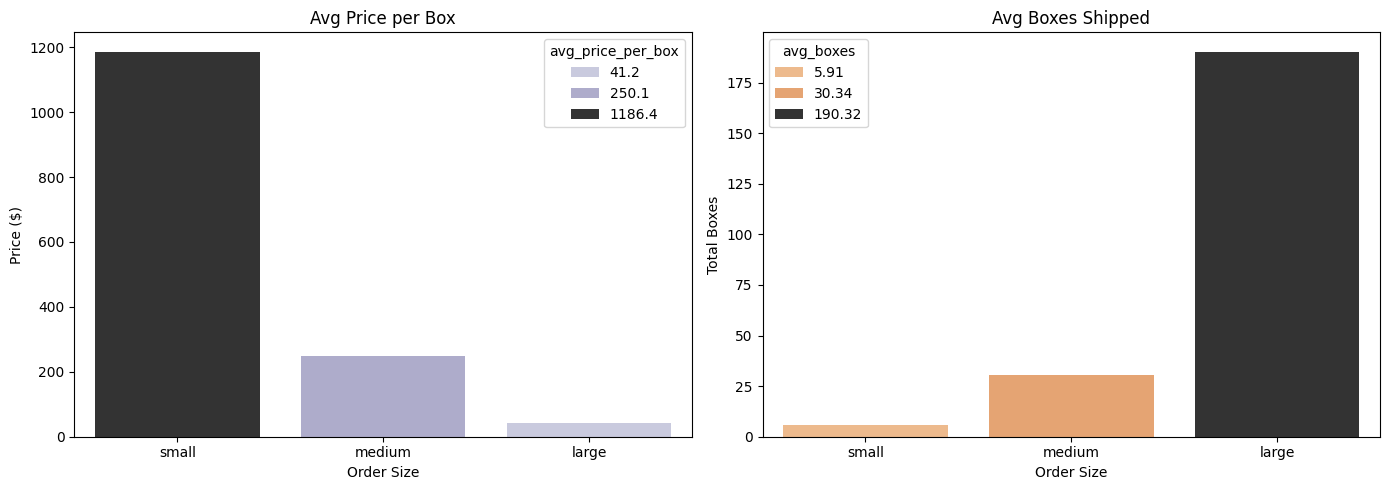

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=segment_stats, x="order_size", y="avg_price_per_box", ax=ax[0], hue="avg_price_per_box", palette="Purples_d")
ax[0].set_title("Avg Price per Box")
ax[0].set_xlabel("Order Size")
ax[0].set_ylabel("Price ($)")

sns.barplot(data=segment_stats, x="order_size", y="avg_boxes", ax=ax[1], hue="avg_boxes", palette="Oranges_d")
ax[1].set_title("Avg Boxes Shipped")
ax[1].set_xlabel("Order Size")
ax[1].set_ylabel("Total Boxes")

plt.tight_layout()
plt.show()

In this case, we can conclude some relevant things:

- **Inverse relationship observed**:
  -  **Large orders**: Lowest unit price (~$41.2), highest volume (~190 boxes)
  -  **Medium orders**: Moderate price (~$250.1), moderate volume (~30 boxes)
  -  **Small orders**: Highest unit price (~$1,186.4), lowest volume (~6 boxes)

- **Strategic insight**:
  - Small orders offer **high margins per box**
  - Large orders drive **sales volume and scale**
  - A balanced approach may optimize both **profitability and revenue**

## 5. Conclusion

To focus this conclusion, I will make a supositions like how much does a chocolate cost, and how much does a chocolate box cost. 

Why I will do that? Because I think that is a good way to understand the data and the business in order to approach the analysis to a more realistic situation.

In [19]:
segment_stats["revenue_per_box"] = segment_stats["avg_revenue"] / segment_stats["avg_boxes"]

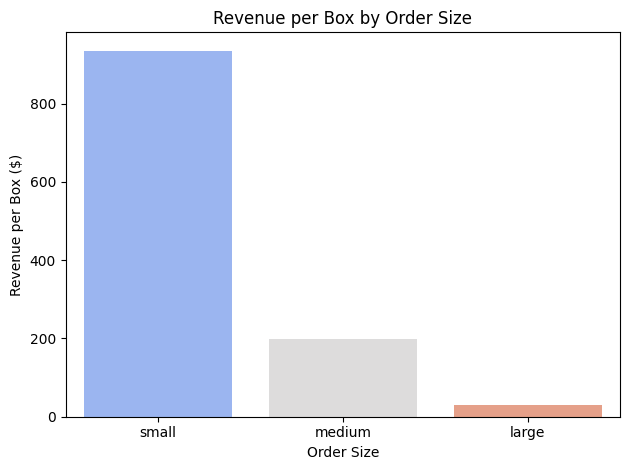

In [20]:
sns.barplot(data=segment_stats, x="order_size", y="revenue_per_box", hue="order_size", palette="coolwarm")
plt.title("Revenue per Box by Order Size")
plt.ylabel("Revenue per Box ($)")
plt.xlabel("Order Size")
plt.tight_layout()
plt.show()

It's clear that these market is price scaled-based. Small orders are more expensive than big orders but which profit is higher? I think that is a good question to ask. 

But this calculus of costs is so basic. Moreover is a simulation, we can do it better including the costs of the chocolate, the taxes and the logistics. Is not 100% accurate, but is a good approximation to understand the behavior of the sales.

In [21]:
def calculate_cost_row(row):
    # Static costs
    chocolate_cost = 12 * row["boxes_shipped"]
    tax_cost = 0.10 * row["amount"]

    # Variable costs
    if row["boxes_shipped"] <= 6: # Small
        logistic_cost_box = 5
    elif row["boxes_shipped"] <= 30: # Medium
        logistic_cost_box = 3
    else:
        logistic_cost_box = 1.5 # Large

    logistic_cost = logistic_cost_box * row["boxes_shipped"]

    # Total cost
    total_cost = chocolate_cost + tax_cost + logistic_cost
    return chocolate_cost, tax_cost, logistic_cost, total_cost

In [22]:
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large


In [23]:
df[["chocolate_cost", "tax_cost", "logistic_cost", "cost"]] = df.apply(calculate_cost_row, axis=1, result_type="expand")
df["profit"] = df["amount"] - df["cost"]
df["profit_margin"] = (df["profit"] / df["amount"]) * 100

df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size,chocolate_cost,tax_cost,logistic_cost,cost,profit,profit_margin
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large,2160.0,532.0,270.0,2962.0,2358.0,44.323308
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large,1128.0,789.6,141.0,2058.6,5837.4,73.928571
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large,1092.0,450.1,136.5,1678.6,2822.4,62.706065
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large,4104.0,1272.6,513.0,5889.6,6836.4,53.719943
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large,2208.0,1368.5,276.0,3852.5,9832.5,71.848739


Okey now, let's know how much does it cost a order by size:

In [24]:
avg_cost_by_order = (
    df.groupby("order_size", observed=True)["cost"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"cost": "avg_cost"})
)

display(avg_cost_by_order)


,order_size,avg_cost
0,small,645.62
1,medium,1032.04
2,large,3127.97


And which percentage represents each cost of the total cost?

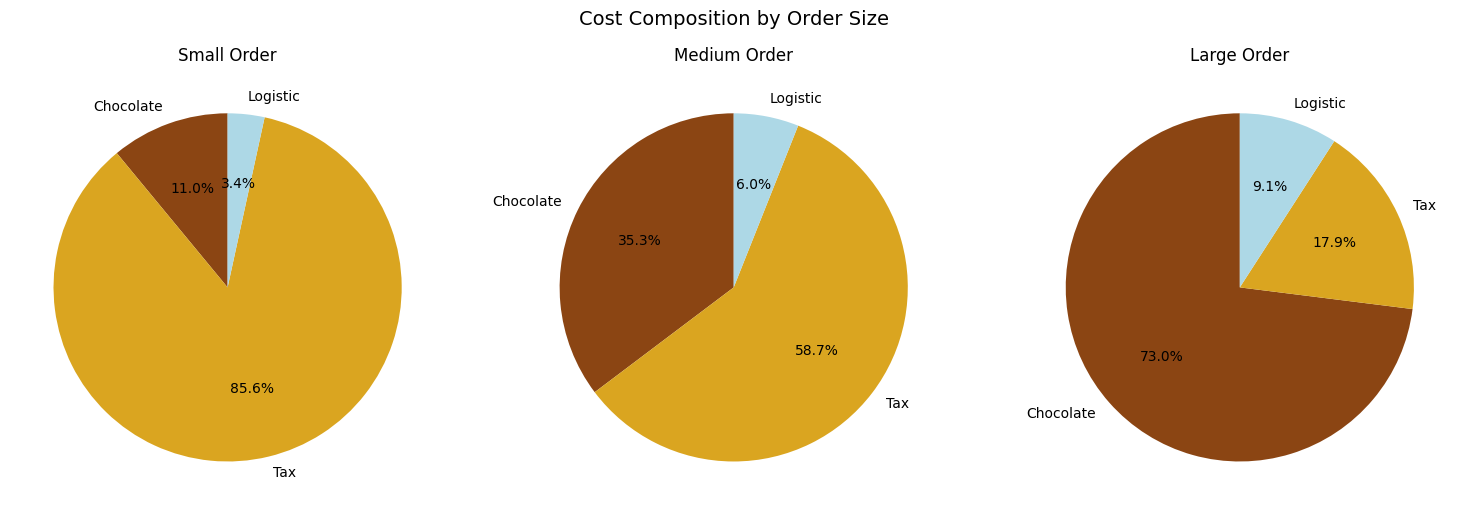

In [25]:
segmented_costs = df.groupby("order_size", observed=True)[["chocolate_cost", "tax_cost", "logistic_cost", "cost"]].sum().reset_index()

# For each order size, get the cost components
order_sizes = segmented_costs["order_size"]
components = ["chocolate_cost", "tax_cost", "logistic_cost"]
colors = ["saddlebrown", "goldenrod", "lightblue"]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, size in enumerate(order_sizes):
    # Get the cost values for this order size
    costs = segmented_costs.loc[i, components].values
    axs[i].pie(
        costs,
        labels=["Chocolate", "Tax", "Logistic"],
        colors=colors,
        autopct="%1.1f%%",
        startangle=90
    )
    axs[i].set_title(f"{size.capitalize()} Order")

plt.suptitle("Cost Composition by Order Size", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

And now, it's the time that all we were waiting for. Let's see the profit of each order size:

In [26]:
benefits = df.groupby("order_size", observed=True).agg({"amount": "sum", "cost": "sum", "profit": "sum"}).round(2)

benefits["profit_margin"] = (benefits["profit"] / benefits["amount"]) * 100
benefits = benefits.round(2)
benefits

,amount,cost,profit,profit_margin
order_size,,,,
small,182385.0,21305.5,161079.5,88.32
medium,950873.0,162030.8,788842.2,82.96
large,5050367.0,2827684.7,2222682.3,44.01


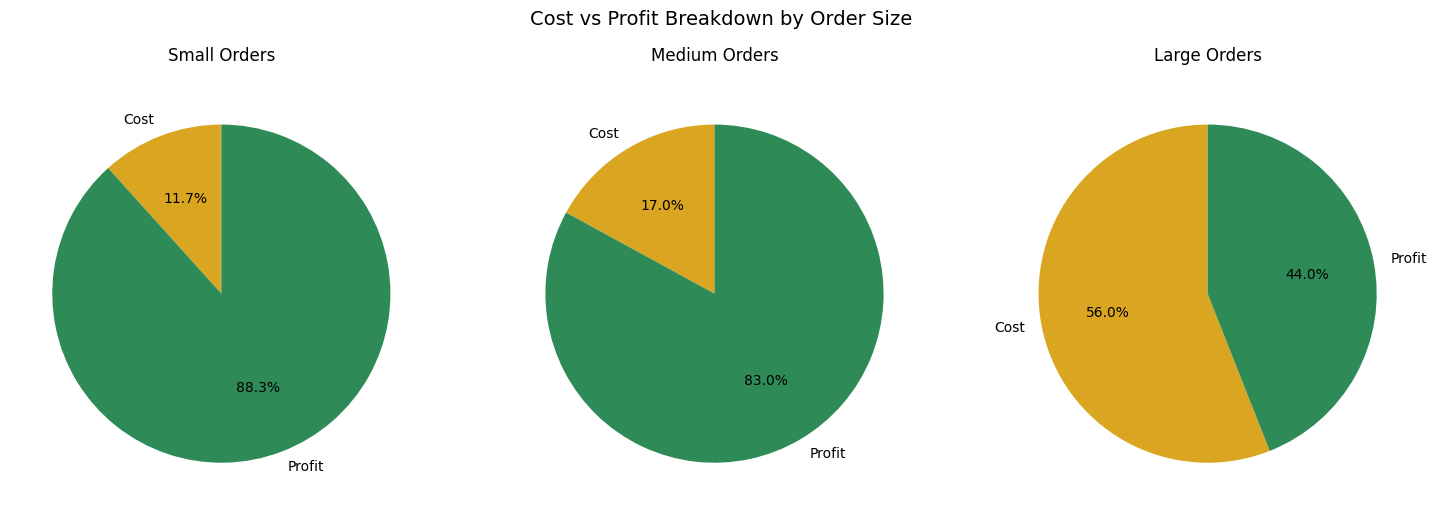

In [27]:
labels = ["Cost", "Profit"]
colors = ["goldenrod", "seagreen"]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, size in enumerate(benefits.index):
    cost = benefits.loc[size, "cost"]
    profit = benefits.loc[size, "profit"]
    axs[i].pie(
        [cost, profit],
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90
    )
    axs[i].set_title(f"{size.capitalize()} Orders", pad=15)

plt.suptitle("Cost vs Profit Breakdown by Order Size", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

It's interesting because:

- **Small orders** are the most profitable, with only **11.7% cost** and **88.3% profit margin**.
- **Medium orders** maintain a strong profitability, with **83% profit**.
- **Large orders**, while generating higher revenue, have significantly **lower margins** due to **higher operational costs (56%)**.

This highlights the trade-off between **volume** and **profitability**, suggesting small and medium orders are more cost-efficient.


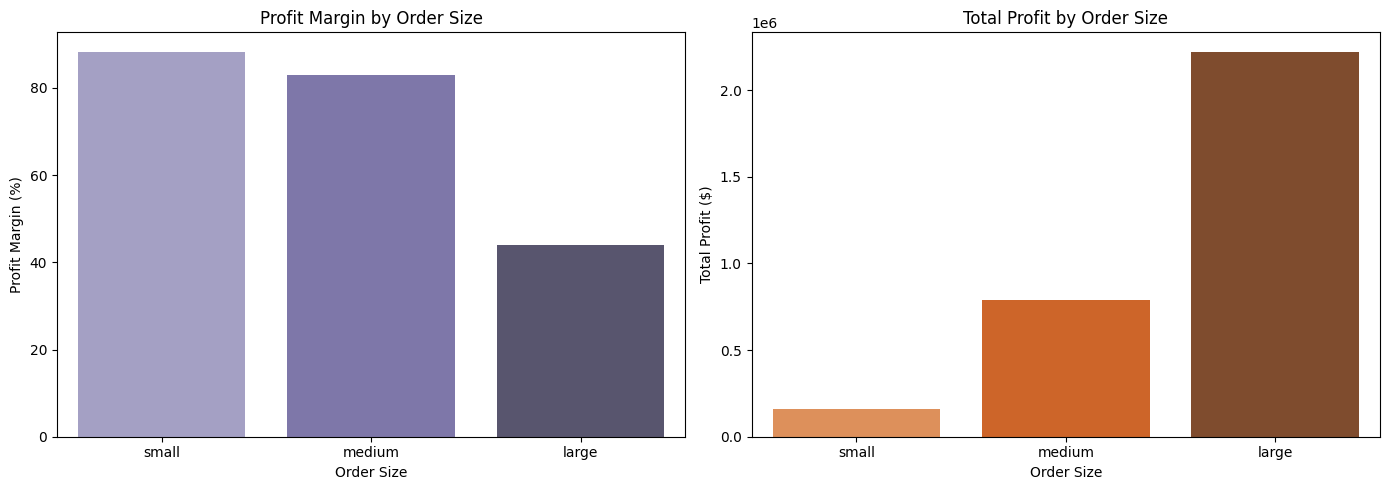

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=benefits, x="order_size", y="profit_margin", ax=ax[0], hue="order_size", palette="Purples_d")
ax[0].set_title("Profit Margin by Order Size")
ax[0].set_xlabel("Order Size")
ax[0].set_ylabel("Profit Margin (%)")

sns.barplot(data=benefits, x="order_size", y="profit", ax=ax[1], hue="order_size", palette="Oranges_d")
ax[1].set_title("Total Profit by Order Size")
ax[1].set_xlabel("Order Size")
ax[1].set_ylabel("Total Profit ($)")

plt.tight_layout()
plt.show()

Based on the analysis of profit margin and total profit across different order sizes, the following conclusions can be drawn:

1. **High Unit Profitability in Small Orders vs. High Volume Profit in Large Orders**
   
   Small orders yield the highest **profit margin**, exceeding **85%**, followed closely by medium orders at around **80%**. In contrast, large orders show a significantly lower margin (around **45%**), yet they generate the highest **total profit**, surpassing **$2 million**.

    > **Interpretation**:  
    > Small orders are more profitable **per dollar sold**, but large orders are more profitable **in absolute terms** due to their scale.

2. **Strategic Trade-off: Margin vs. Volume**

    This result reveals a classic **business trade-off**:
    - Smaller orders = **higher margins** but lower volume  
    - Larger orders = **lower margins** but **much higher profit volume**

    >  **Strategic Implication**:  
    > If the business aims to **maximize profitability per unit**, targeting small or medium orders may be ideal — such as individual or boutique clients.  
    > However, if the goal is to **maximize total profit**, then focusing on large-scale orders remains the most effective path.

3. **Optimization Potential**

    A hybrid strategy could offer the best outcome:
    - **Maintain premium pricing** for small orders (justified by convenience, branding, or packaging)
    - **Reduce cost structures** (especially logistics and tax optimization) in large orders to recover margins while maintaining volume.

# 6. Extra section: Interesting facts

## 6.1. Best sales person for big orders

Finishing my prevoius analysis, I had some questions as WHO is the sales person that sells more large orders? Because we saw that these orders made more money. So, for me is also interesting who is selling more but also who is selling better.

In [30]:
big_orders = df[df["order_size"] == "large"]
top_big_sales = big_orders["sales_person"].value_counts().reset_index()
top_big_sales.columns = ["sales_person", "total_big_sales"]
top_big_sales


,sales_person,total_big_sales
0,Kelci Walkden,45
1,Beverie Moffet,43
2,Ches Bonnell,42
3,Gigi Bohling,42
4,Brien Boise,41
5,Karlen McCaffrey,41
6,Oby Sorrel,40
7,Dennison Crosswaite,39
8,Curtice Advani,38
9,Kaine Padly,38


In [31]:
total_sales = df["sales_person"].value_counts().reset_index()
total_sales.columns = ["sales_person", "total_sales"]

# Merge top big orders sales persons with total sales
df_merged = pd.merge(top_big_sales, total_sales, on="sales_person", how="left")
df_merged["big_sales_percentage"] = (df_merged["total_big_sales"] / df_merged["total_sales"]) * 100
df_merged = df_merged.sort_values(by="big_sales_percentage", ascending=False)
df_merged

,sales_person,total_big_sales,total_sales,big_sales_percentage
18,Dotty Strutley,33,36,91.666667
20,Rafaelita Blaksland,31,34,91.176471
3,Gigi Bohling,42,47,89.361702
2,Ches Bonnell,42,48,87.500000
5,Karlen McCaffrey,41,47,87.234043
17,Jan Morforth,34,39,87.179487
1,Beverie Moffet,43,50,86.000000
9,Kaine Padly,38,45,84.444444
13,Jehu Rudeforth,36,43,83.720930
0,Kelci Walkden,45,54,83.333333


We can see that the sales person who sells more large orders is `Dotty Strutley`, with 33 large orders which represents 91.6% of his total orders.

And if we add the total profit of each sales person? It will have some relatiionship that the sales person who sells more large orders is also the one who makes more money? In fact, we saw in the prevoius analysis that small orders are more profitable. So it will depend of the volume.

## 6.2. Sales person clustering

Maybe if we make a clustering of the sales person, we can see some interesting things. I will use KMeans to make a clustering of the sales person based on the total profit and the average profit.

The objective is to find the best group of sales person and what are their doing to generate more profit.

In [32]:
df.head()

,sales_person,country,product,date,amount,boxes_shipped,month,price_per_box,order_size,chocolate_cost,tax_cost,logistic_cost,cost,profit,profit_margin
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180,2022-01,29.555556,large,2160.0,532.0,270.0,2962.0,2358.0,44.323308
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94,2022-08,84.000000,large,1128.0,789.6,141.0,2058.6,5837.4,73.928571
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91,2022-07,49.461538,large,1092.0,450.1,136.5,1678.6,2822.4,62.706065
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,2022-04,37.210526,large,4104.0,1272.6,513.0,5889.6,6836.4,53.719943
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,2022-02,74.375000,large,2208.0,1368.5,276.0,3852.5,9832.5,71.848739


Here is the dataframe with the clustering of the sales person:

In [ ]:
df_cluster = df[["sales_person", "order_size", "country", "product"]].copy()

total_sales = df["sales_person"].value_counts().rename("total_sales")

orders_type = df.groupby(["sales_person", "order_size"], observed=True).size().unstack(fill_value=0)
orders_type.columns = ["small_orders", "medium_orders", "large_orders"]

big_orders_percentage = ((orders_type["large_orders"] / total_sales) * 100).rename("big_orders_percentage").round(2)
total_profit = df.groupby("sales_person", observed=True)["profit"].sum().rename("total_profit").round(2)
avg_total_profit = (total_profit / total_sales).rename("avg_total_profit").round(2)
avg_big_orders_profit = df[df["order_size"] == "large"].groupby("sales_person")["profit"].mean().rename("avg_big_orders_profit").round(2)

df_cluster = pd.concat([
    total_sales,
    orders_type,
    big_orders_percentage,
    total_profit,
    avg_total_profit,
    avg_big_orders_profit
], axis=1).reset_index().rename(columns={"index": "sales_person"})

df_cluster.head(10)

,sales_person,total_sales,small_orders,medium_orders,large_orders,big_orders_percentage,total_profit,avg_total_profit,avg_big_orders_profit
0,Kelci Walkden,54,2,7,45,83.33,162906.0,3016.78,2695.62
1,Brien Boise,53,1,11,41,77.36,171885.9,3243.13,2772.61
2,Van Tuxwell,51,4,10,37,72.55,180868.6,3546.44,2789.56
3,Beverie Moffet,50,2,5,43,86.00,126501.3,2530.03,2075.17
4,Dennison Crosswaite,49,1,9,39,79.59,143943.6,2937.62,2737.22
5,Oby Sorrel,49,0,9,40,81.63,168657.0,3441.98,2738.05
6,Ches Bonnell,48,0,6,42,87.50,187170.9,3899.39,3600.94
7,Karlen McCaffrey,47,2,4,41,87.23,71081.0,1512.36,1282.46
8,Gigi Bohling,47,2,3,42,89.36,124281.4,2644.29,2376.02
9,Curtice Advani,46,3,5,38,82.61,99161.4,2155.68,1684.82


Now applying KMeans clusterization:

In [34]:
features = [
    "total_sales",
    "small_orders",
    "medium_orders",
    "large_orders",
    "big_orders_percentage",
    "total_profit",
    "avg_total_profit",
    "avg_big_orders_profit"
]

X = df_cluster[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)
df_cluster.groupby("cluster")[features].mean().round(2)

,total_sales,small_orders,medium_orders,large_orders,big_orders_percentage,total_profit,avg_total_profit,avg_big_orders_profit
cluster,,,,,,,,
0,45.20,2.00,3.80,39.40,87.37,100004.64,2207.35,1874.96
1,39.92,0.92,6.23,32.77,82.13,113157.09,2837.92,2375.24
2,49.86,1.57,8.14,40.14,80.60,171648.37,3460.15,2994.08


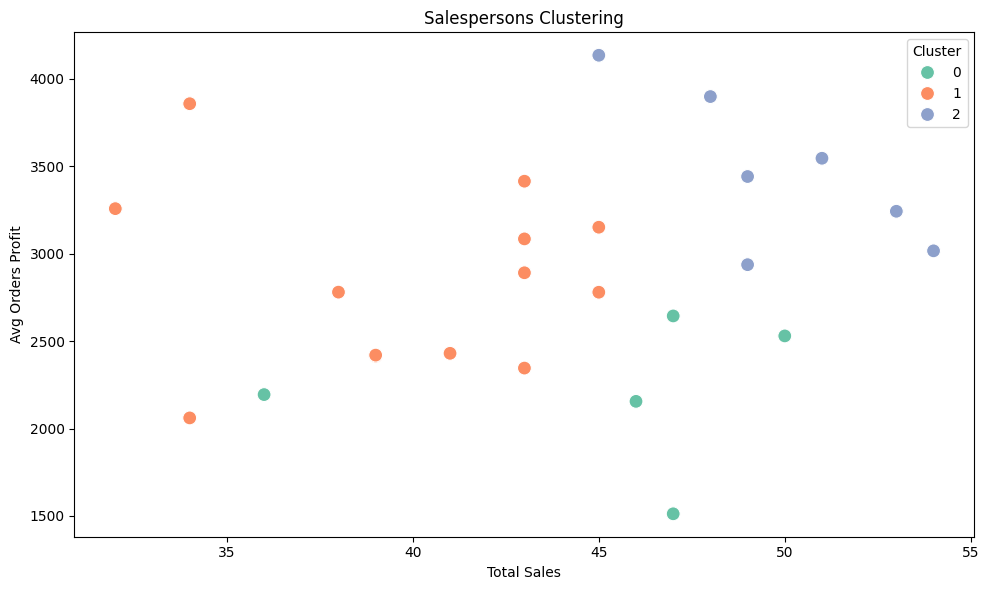

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x="total_sales",
    y="avg_total_profit",
    hue="cluster",
    palette="Set2",
    s=100,
)
plt.title("Salespersons Clustering")
plt.xlabel("Total Sales")
plt.ylabel("Avg Orders Profit")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

The clustering algorithm successfully segmented salespersons into **three distinct behavioral profiles** based on `Total Sales` and `Average Order Profit`:

- 🟠 **Cluster 1**: Low sales volume but **high average profit per order**  
  → Likely focused on **premium, high-margin deals**.

- 🔵 **Cluster 2**: High volume and above-average profit  
  → These are the **top performers**, balancing **quantity and quality** effectively.

- 🟢 **Cluster 0**: Medium-to-high sales with **lower average profit**  
  → Likely **operational sellers**, prioritizing volume over margin.

But, I don't know if this clusterization is optimal. So, in order to be calm, I will try to know if our clusterization is optimal or not.

First, I will use the elbow method which is a heuristic used in determining the number of clusters in a dataset. It works by plotting the explained variation as a function of the number of clusters and selecting the elbow of the curve as the number of clusters to use.

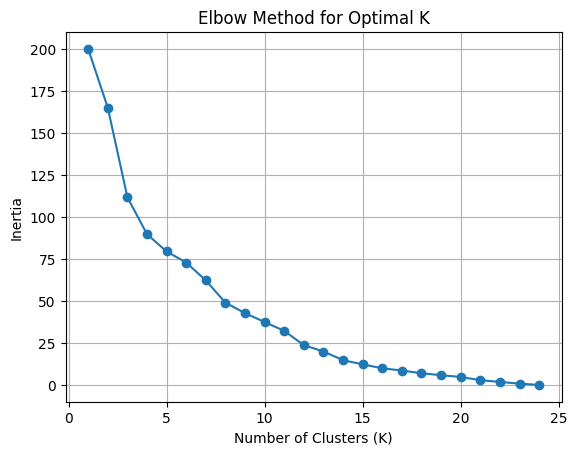

In [36]:
inertias = []
K_range = range(1, 25)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

Yeah, is not the best elbow, but I think that is a good clusterization.

Just in case, I will use the silhouette method to validate the clusterization. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a value close to 1 indicates that the object is well clustered, a value close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters, and a value close to -1 indicates that the object might have been assigned to the wrong cluster.

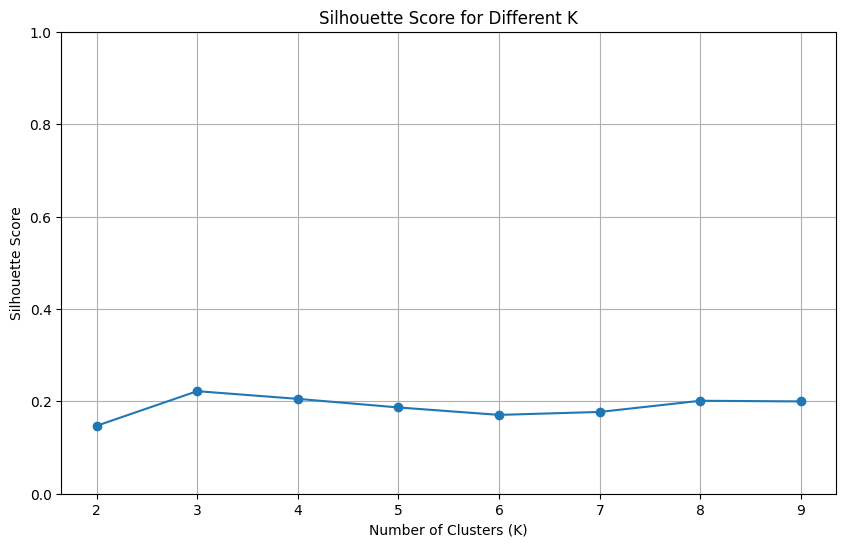

In [37]:
scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, scores, marker="o")
plt.title("Silhouette Score for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Okey, 3 clusters seems to be the best option.

Let's make a PCA to reduce the dimensionality of the data and see if we can find some interesting things.

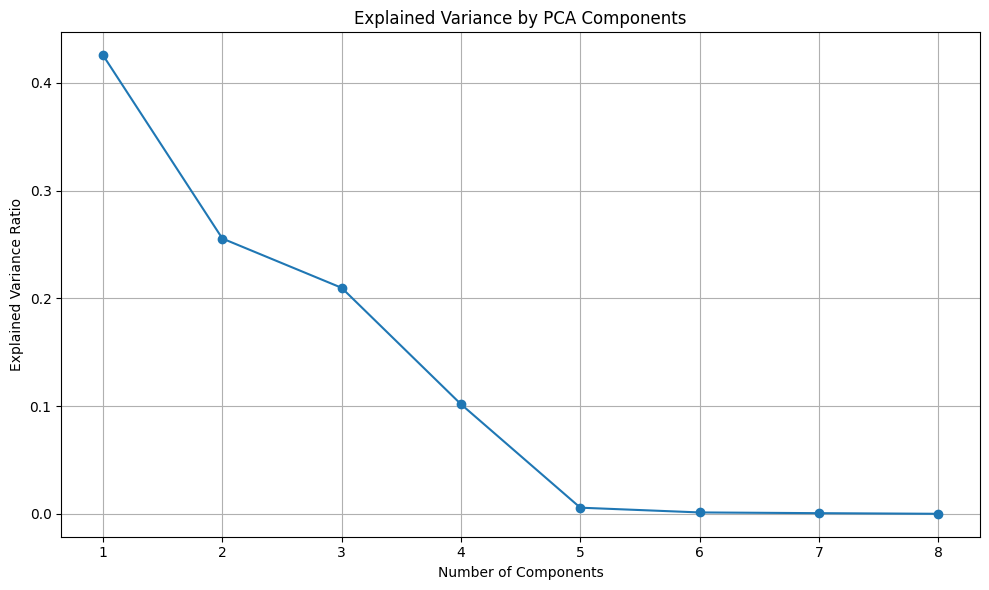

In [38]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o")
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))],
)
loadings = loadings.round(2)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
total_sales,0.40,-0.33,0.34,-0.17,0.11,0.01,-0.17,0.74
small_orders,0.13,-0.43,0.09,0.83,0.06,0.29,-0.04,-0.13
medium_orders,0.33,-0.29,-0.43,-0.41,0.14,0.59,-0.09,-0.26
large_orders,0.32,-0.19,0.57,-0.21,0.06,-0.31,-0.16,-0.61
big_orders_percentage,-0.19,0.39,0.58,-0.07,-0.07,0.68,-0.01,-0.00
total_profit,0.53,0.14,0.02,0.04,-0.39,0.03,0.74,0.00
avg_total_profit,0.41,0.41,-0.17,0.18,-0.47,-0.01,-0.62,-0.00
avg_big_orders_profit,0.36,0.50,-0.06,0.17,0.77,-0.04,0.05,-0.00


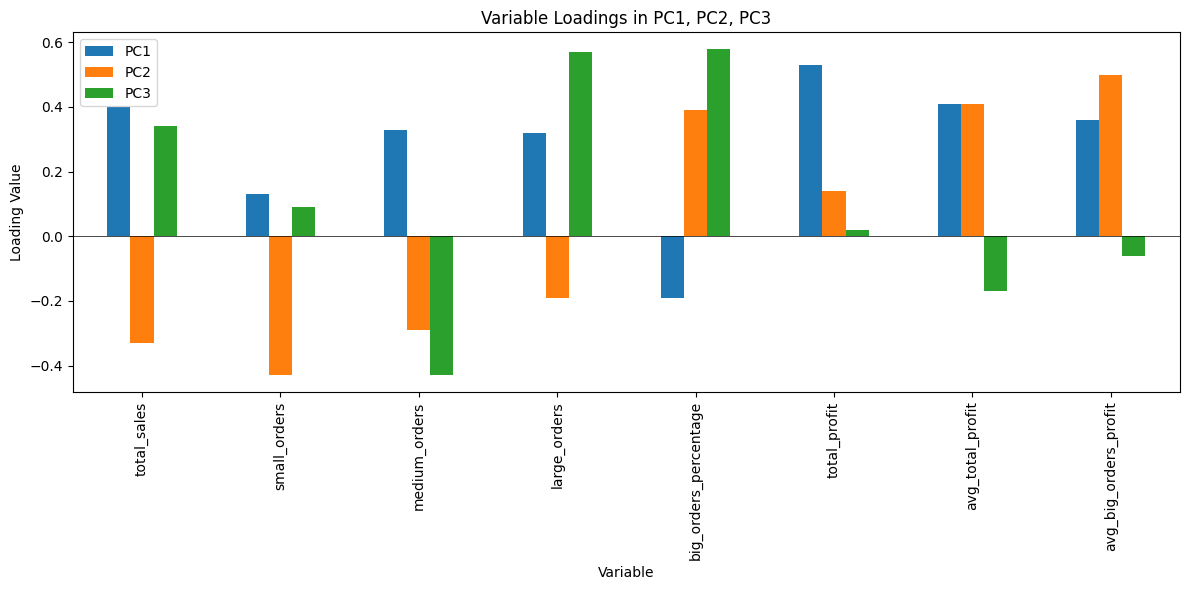

In [40]:
loadings_top3 = loadings[["PC1", "PC2", "PC3"]]

loadings_top3.plot(kind='bar', figsize=(12, 6))
plt.title("Variable Loadings in PC1, PC2, PC3")
plt.ylabel("Loading Value")
plt.xlabel("Variable")
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Variables to maintain:
- `total_sales`
- `total_profit`
- `total_orders`
- `big_orders_percentage`
- `avg_total_profit`

Optional variables:
- `avg_big_orders_profit`
- `medium_orders`

Discard:
- `small_orders`

In [41]:
key_var = [
    "total_sales",
    "large_orders",
    "big_orders_percentage",
    "total_profit",
    "avg_total_profit",
]

new_df_cluster = df_cluster[["sales_person"] + key_var.copy()]

new_df_cluster.head()

,sales_person,total_sales,large_orders,big_orders_percentage,total_profit,avg_total_profit
0,Kelci Walkden,54,45,83.33,162906.0,3016.78
1,Brien Boise,53,41,77.36,171885.9,3243.13
2,Van Tuxwell,51,37,72.55,180868.6,3546.44
3,Beverie Moffet,50,43,86.00,126501.3,2530.03
4,Dennison Crosswaite,49,39,79.59,143943.6,2937.62


In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_df_cluster[key_var])

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
new_df_cluster = new_df_cluster.copy() # Create a copy to avoid SettingWithCopyWarning
new_df_cluster["cluster"] = kmeans.fit_predict(X_scaled)
new_df_cluster.groupby("cluster")[key_var].mean().round(2)

,total_sales,large_orders,big_orders_percentage,total_profit,avg_total_profit
cluster,,,,,
0,44.00,38.14,86.82,99295.84,2256.77
1,39.20,31.80,81.23,113415.75,2898.04
2,49.25,39.88,81.08,167921.95,3421.62


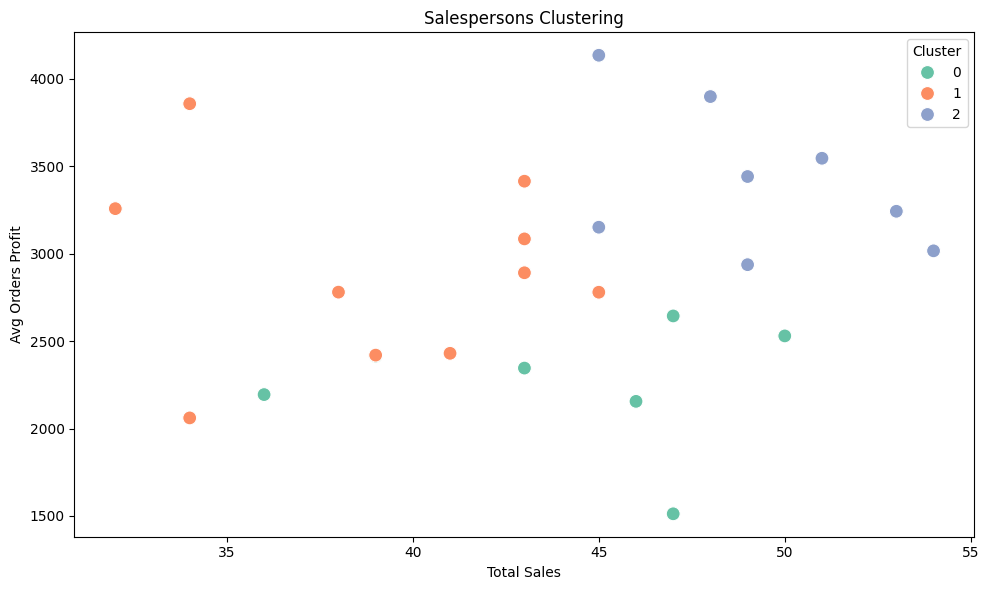

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=new_df_cluster,
    x="total_sales",
    y="avg_total_profit",
    hue="cluster",
    palette="Set2",
    s=100,
)
plt.title("Salespersons Clustering")
plt.xlabel("Total Sales")
plt.ylabel("Avg Orders Profit")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

The result is practically the same.